In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import pickle

C:\Users\hskay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "meta-llama/Llama-2-7b-chat-hf"
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.float16,
    device_map='auto' if torch.cuda.is_available() else None
)
model.eval()


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_e

In [6]:
model.parameters

<bound method Module.parameters of LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNor

In [4]:
# Helper function to capture activations
def get_activation(name, activations_dict):
    def hook(module, input, output):
        # Handle different output types
        if isinstance(output, tuple):
            activations_dict[name] = output[0].detach().clone()
        else:
            activations_dict[name] = output.detach().clone()
    return hook

In [ ]:
# Generate sample inputs for analysis
def generate_sample_inputs(tokenizer, seq_length=32):    
    sample_texts = [
        "The quick brown fox jumps over the lazy dog.",
        "Artificial intelligence is transforming the world of technology.",
        "In a hole in the ground there lived a hobbit.",
        "To be or not to be, that is the question Shakespeare posed.",
        "Machine learning models require large datasets for training.",
        "The mitochondria is the powerhouse of the cell in biology.",
        "Climate change is causing unprecedented shifts in global weather patterns.",
        "Mozart composed his first symphony at the age of eight years old.",
        "The stock market experienced significant volatility during the pandemic crisis.",
        "Quantum physics reveals the strange behavior of particles at subatomic levels.",
        "Professional chefs recommend using fresh herbs to enhance flavor profiles.",
        "Ancient Egyptian pyramids were built using sophisticated engineering techniques.",
        "Regular exercise and proper nutrition are essential for maintaining good health.",
        "The International Space Station orbits Earth approximately every ninety minutes.",
        "Cryptocurrency markets operate twenty-four hours a day across global exchanges.",
        "Vincent van Gogh painted Starry Night while staying at an asylum.",
        "Professional athletes must maintain strict training regimens throughout their careers.",
        "The Amazon rainforest produces twenty percent of the world's oxygen supply.",
        "Modern architecture emphasizes clean lines and functional design principles.",
        "Forensic scientists use DNA analysis to solve complex criminal investigations.",
        "Traditional Japanese tea ceremonies follow centuries-old ritualistic practices.",
        "Marine biologists study coral reef ecosystems threatened by ocean acidification.",
        "The Renaissance period marked a cultural rebirth in European art and science.",
        "Cybersecurity experts work tirelessly to protect digital infrastructure from threats.",
        "Sustainable agriculture practices help preserve soil quality for future generations."
    ]
    
    inputs = []
    for i in range(len(sample_texts)):
        # Cycle through sample texts and add variations
        base_text = sample_texts[i % len(sample_texts)]

        # Tokenize
        tokenized = tokenizer(
            base_text, 
            return_tensors="pt", 
            padding='max_length', 
            truncation=True, 
            max_length=seq_length
        )
        inputs.append(tokenized.input_ids.to(model.device))
    
    return inputs

In [ ]:
# Generate activation differences for Llama-2 layers
def generate_activation_differences_llama(model, X_data, n_samples=50, n_reconstructions=3):
    results = []
    
    # Select specific layers to analyze (first few transformer layers)
    # layer_names = [
    #     'model.layers.0',  # First transformer layer
    #     'model.layers.1',  # Second transformer layer  
    #     'model.layers.2',  # Third transformer layer
    # ]
    layer_names = [f'model.layers.{i}' for i in range(len(model.model.layers))]
    for sample_idx in tqdm(range(min(n_samples, len(X_data))), desc="Processing samples"):
        original_input = X_data[sample_idx]
        
        # Get original activations
        original_activations = {}
        hooks = []
        
       # Register hooks for all layers
        for layer_name in layer_names:
            layer_module = model
            for attr in layer_name.split('.'):
                layer_module = getattr(layer_module, attr)
            hooks.append(layer_module.register_forward_hook(
                get_activation(layer_name, original_activations)
            ))
        
        # Get original output and activations
        with torch.no_grad():
            original_output = model(original_input).logits
        
        # Remove hooks
        for hook in hooks:
            hook.remove()
        
        # Multiple reconstruction attempts
        for recon_idx in range(n_reconstructions):
            # Initialize random input embeddings for reconstruction
            seq_length = original_input.shape[1]
            embedding_dim = model.config.hidden_size
            
            # Use embeddings instead of token IDs for gradient-based optimization
            reconstructed_embeddings = torch.randn(
                1, seq_length, embedding_dim,
                device=model.device,
                dtype=torch.float32,
                requires_grad=True
            )
            
            optimizer = optim.Adam([reconstructed_embeddings], lr=0.001)
            
            # Reconstruction optimization
            for iteration in range(10000): 
                optimizer.zero_grad()
                
                # Forward pass with embeddings
                embeddings_model_dtype = reconstructed_embeddings.to(model.dtype)
                output = model(inputs_embeds=embeddings_model_dtype).logits
                
                # Loss: match original output
                loss = nn.functional.mse_loss(output.float(), original_output.float())
                
                # Add regularization
                reg_loss = 0.001 * torch.mean(reconstructed_embeddings ** 2)
                total_loss = loss + reg_loss
                
                total_loss.backward()
                optimizer.step()
                
                if total_loss.item() < 1e-3:
                    break
                if iteration % 1000 == 0:
                    print(f"{"\r"}Sample {sample_idx}, Recon {recon_idx}, Iter {iteration}, Loss: {total_loss.item():.6f}",end="")
            
            # Get reconstructed activations
            reconstructed_activations = {}
            hooks = []
            
            for layer_name in layer_names:
                layer_module = model
                for attr in layer_name.split('.'):
                    layer_module = getattr(layer_module, attr)
                hooks.append(layer_module.register_forward_hook(
                    get_activation(layer_name, reconstructed_activations)
                ))
            
            with torch.no_grad():
                embeddings_model_dtype = reconstructed_embeddings.to(model.dtype)
                _ = model(inputs_embeds=embeddings_model_dtype)
            
            # Remove hooks
            for hook in hooks:
                hook.remove()
            
            # Calculate differences for each layer
            row = {'sample_idx': sample_idx, 'reconstruction_idx': recon_idx}
            
            # Store individual layer metrics
            all_layer_max_diffs = []
            
            for layer_name in layer_names:
                if layer_name in original_activations and layer_name in reconstructed_activations:
                    orig_act = original_activations[layer_name].flatten().float()
                    recon_act = reconstructed_activations[layer_name].flatten().float()
                    
                    abs_diff = torch.abs(orig_act - recon_act)
                    
                    layer_short = layer_name.split('.')[-1]  # Get layer number
                    row[f'layer_{layer_short}_min_abs_diff'] = abs_diff.min().item()
                    row[f'layer_{layer_short}_mean_abs_diff'] = abs_diff.mean().item()
                    row[f'layer_{layer_short}_max_abs_diff'] = abs_diff.max().item()
                    
                    all_layer_max_diffs.append(abs_diff.max().item())
            
            # Store the maximum difference across ALL layers
            if all_layer_max_diffs:
                row['all_layers_max_diff'] = max(all_layer_max_diffs)
                row['all_layers_min_of_max'] = min(all_layer_max_diffs)
            
            results.append(row)
    
    return pd.DataFrame(results)

In [7]:
# Generate sample data
print("Generating sample inputs...")
X_data = generate_sample_inputs(tokenizer, n_samples=20, seq_length=16) 
print(f"Generated {len(X_data)} samples")

Generating sample inputs...
Generated 20 samples


In [ ]:
# Generate results
print("Generating activation differences for Llama-2 layers...")
results = generate_activation_differences_llama(model, X_data, n_samples=10, n_reconstructions=3)
#406m 40.9s

Generating activation differences for Llama-2 layers...


Processing samples:   0%|          | 0/10 [00:00<?, ?it/s]

Sample 0, Recon 0, Iter 0, Loss: 18.072140
Sample 0, Recon 0, Iter 100, Loss: 6.001960
Sample 0, Recon 0, Iter 200, Loss: 4.446840
Sample 0, Recon 0, Iter 300, Loss: 3.604485
Sample 0, Recon 0, Iter 400, Loss: 3.302956
Sample 0, Recon 0, Iter 500, Loss: 3.122141
Sample 0, Recon 0, Iter 600, Loss: 2.971247
Sample 0, Recon 0, Iter 700, Loss: 2.826409
Sample 0, Recon 0, Iter 800, Loss: 2.680085
Sample 0, Recon 0, Iter 900, Loss: 2.532717
Sample 0, Recon 0, Iter 1000, Loss: 2.393804
Sample 0, Recon 0, Iter 1100, Loss: 2.269571
Sample 0, Recon 0, Iter 1200, Loss: 2.159087
Sample 0, Recon 0, Iter 1300, Loss: 2.060229
Sample 0, Recon 0, Iter 1400, Loss: 1.970483
Sample 0, Recon 0, Iter 1500, Loss: 1.888022
Sample 0, Recon 0, Iter 1600, Loss: 1.811693
Sample 0, Recon 0, Iter 1700, Loss: 1.740411
Sample 0, Recon 0, Iter 1800, Loss: 1.674420
Sample 0, Recon 0, Iter 1900, Loss: 1.613055
Sample 0, Recon 0, Iter 2000, Loss: 1.555785
Sample 0, Recon 0, Iter 2100, Loss: 1.502473
Sample 0, Recon 0, It

Processing samples:  10%|█         | 1/10 [40:42<6:06:23, 2442.61s/it]

Sample 1, Recon 0, Iter 0, Loss: 18.817217
Sample 1, Recon 0, Iter 100, Loss: 6.056330
Sample 1, Recon 0, Iter 200, Loss: 4.589106
Sample 1, Recon 0, Iter 300, Loss: 3.701640
Sample 1, Recon 0, Iter 400, Loss: 3.357178
Sample 1, Recon 0, Iter 500, Loss: 3.164711
Sample 1, Recon 0, Iter 600, Loss: 3.012650
Sample 1, Recon 0, Iter 700, Loss: 2.877337
Sample 1, Recon 0, Iter 800, Loss: 2.747234
Sample 1, Recon 0, Iter 900, Loss: 2.616783
Sample 1, Recon 0, Iter 1000, Loss: 2.485771
Sample 1, Recon 0, Iter 1100, Loss: 2.362695
Sample 1, Recon 0, Iter 1200, Loss: 2.257669
Sample 1, Recon 0, Iter 1300, Loss: 2.167194
Sample 1, Recon 0, Iter 1400, Loss: 2.085522
Sample 1, Recon 0, Iter 1500, Loss: 2.009644
Sample 1, Recon 0, Iter 1600, Loss: 1.937713
Sample 1, Recon 0, Iter 1700, Loss: 1.869321
Sample 1, Recon 0, Iter 1800, Loss: 1.804370
Sample 1, Recon 0, Iter 1900, Loss: 1.742591
Sample 1, Recon 0, Iter 2000, Loss: 1.684048
Sample 1, Recon 0, Iter 2100, Loss: 1.629177
Sample 1, Recon 0, It

Processing samples:  20%|██        | 2/10 [1:21:06<5:24:11, 2431.44s/it]

Sample 2, Recon 0, Iter 0, Loss: 17.252518
Sample 2, Recon 0, Iter 100, Loss: 4.607908
Sample 2, Recon 0, Iter 200, Loss: 3.768399
Sample 2, Recon 0, Iter 300, Loss: 3.402176
Sample 2, Recon 0, Iter 400, Loss: 3.168390
Sample 2, Recon 0, Iter 500, Loss: 2.995996
Sample 2, Recon 0, Iter 600, Loss: 2.857948
Sample 2, Recon 0, Iter 700, Loss: 2.740199
Sample 2, Recon 0, Iter 800, Loss: 2.627674
Sample 2, Recon 0, Iter 900, Loss: 2.512667
Sample 2, Recon 0, Iter 1000, Loss: 2.399300
Sample 2, Recon 0, Iter 1100, Loss: 2.288285
Sample 2, Recon 0, Iter 1200, Loss: 2.183577
Sample 2, Recon 0, Iter 1300, Loss: 2.087837
Sample 2, Recon 0, Iter 1400, Loss: 2.000232
Sample 2, Recon 0, Iter 1500, Loss: 1.918835
Sample 2, Recon 0, Iter 1600, Loss: 1.842659
Sample 2, Recon 0, Iter 1700, Loss: 1.772247
Sample 2, Recon 0, Iter 1800, Loss: 1.706420
Sample 2, Recon 0, Iter 1900, Loss: 1.643850
Sample 2, Recon 0, Iter 2000, Loss: 1.584657
Sample 2, Recon 0, Iter 2100, Loss: 1.528299
Sample 2, Recon 0, It

Processing samples:  30%|███       | 3/10 [2:01:28<4:43:10, 2427.28s/it]

Sample 3, Recon 0, Iter 0, Loss: 20.815178
Sample 3, Recon 0, Iter 100, Loss: 4.727788
Sample 3, Recon 0, Iter 200, Loss: 4.329004
Sample 3, Recon 0, Iter 300, Loss: 4.148098
Sample 3, Recon 0, Iter 400, Loss: 3.951496
Sample 3, Recon 0, Iter 500, Loss: 3.790228
Sample 3, Recon 0, Iter 600, Loss: 3.649293
Sample 3, Recon 0, Iter 700, Loss: 3.532684
Sample 3, Recon 0, Iter 800, Loss: 3.422399
Sample 3, Recon 0, Iter 900, Loss: 3.309604
Sample 3, Recon 0, Iter 1000, Loss: 3.169080
Sample 3, Recon 0, Iter 1100, Loss: 3.023308
Sample 3, Recon 0, Iter 1200, Loss: 2.901199
Sample 3, Recon 0, Iter 1300, Loss: 2.777738
Sample 3, Recon 0, Iter 1400, Loss: 2.532162
Sample 3, Recon 0, Iter 1500, Loss: 2.416222
Sample 3, Recon 0, Iter 1600, Loss: 2.333764
Sample 3, Recon 0, Iter 1700, Loss: 2.259716
Sample 3, Recon 0, Iter 1800, Loss: 2.190849
Sample 3, Recon 0, Iter 1900, Loss: 2.125586
Sample 3, Recon 0, Iter 2000, Loss: 2.063579
Sample 3, Recon 0, Iter 2100, Loss: 2.005655
Sample 3, Recon 0, It

Processing samples:  40%|████      | 4/10 [2:41:52<4:02:36, 2426.13s/it]

Sample 4, Recon 0, Iter 0, Loss: 22.247620
Sample 4, Recon 0, Iter 100, Loss: 4.539945
Sample 4, Recon 0, Iter 200, Loss: 3.781294
Sample 4, Recon 0, Iter 300, Loss: 3.455182
Sample 4, Recon 0, Iter 400, Loss: 3.229456
Sample 4, Recon 0, Iter 500, Loss: 3.075818
Sample 4, Recon 0, Iter 600, Loss: 2.948146
Sample 4, Recon 0, Iter 700, Loss: 2.839006
Sample 4, Recon 0, Iter 800, Loss: 2.743369
Sample 4, Recon 0, Iter 900, Loss: 2.655700
Sample 4, Recon 0, Iter 1000, Loss: 2.571412
Sample 4, Recon 0, Iter 1100, Loss: 2.487682
Sample 4, Recon 0, Iter 1200, Loss: 2.403078
Sample 4, Recon 0, Iter 1300, Loss: 2.318426
Sample 4, Recon 0, Iter 1400, Loss: 2.235150
Sample 4, Recon 0, Iter 1500, Loss: 2.153696
Sample 4, Recon 0, Iter 1600, Loss: 2.074239
Sample 4, Recon 0, Iter 1700, Loss: 1.997745
Sample 4, Recon 0, Iter 1800, Loss: 1.925679
Sample 4, Recon 0, Iter 1900, Loss: 1.858283
Sample 4, Recon 0, Iter 2000, Loss: 1.795222
Sample 4, Recon 0, Iter 2100, Loss: 1.735891
Sample 4, Recon 0, It

Processing samples:  50%|█████     | 5/10 [3:22:16<3:22:05, 2425.13s/it]

Sample 5, Recon 0, Iter 0, Loss: 15.805341
Sample 5, Recon 0, Iter 100, Loss: 4.280476
Sample 5, Recon 0, Iter 200, Loss: 3.614552
Sample 5, Recon 0, Iter 300, Loss: 3.262625
Sample 5, Recon 0, Iter 400, Loss: 3.050522
Sample 5, Recon 0, Iter 500, Loss: 2.906803
Sample 5, Recon 0, Iter 600, Loss: 2.789263
Sample 5, Recon 0, Iter 700, Loss: 2.687781
Sample 5, Recon 0, Iter 800, Loss: 2.595409
Sample 5, Recon 0, Iter 900, Loss: 2.508285
Sample 5, Recon 0, Iter 1000, Loss: 2.424669
Sample 5, Recon 0, Iter 1100, Loss: 2.341742
Sample 5, Recon 0, Iter 1200, Loss: 2.255262
Sample 5, Recon 0, Iter 1300, Loss: 2.162829
Sample 5, Recon 0, Iter 1400, Loss: 2.066997
Sample 5, Recon 0, Iter 1500, Loss: 1.973005
Sample 5, Recon 0, Iter 1600, Loss: 1.888705
Sample 5, Recon 0, Iter 1700, Loss: 1.815387
Sample 5, Recon 0, Iter 1800, Loss: 1.750129
Sample 5, Recon 0, Iter 1900, Loss: 1.690473
Sample 5, Recon 0, Iter 2000, Loss: 1.634676
Sample 5, Recon 0, Iter 2100, Loss: 1.581744
Sample 5, Recon 0, It

Processing samples:  60%|██████    | 6/10 [4:03:31<2:42:48, 2442.19s/it]

Sample 6, Recon 0, Iter 0, Loss: 10.266039
Sample 6, Recon 0, Iter 100, Loss: 5.051946
Sample 6, Recon 0, Iter 200, Loss: 3.963484
Sample 6, Recon 0, Iter 300, Loss: 3.457649
Sample 6, Recon 0, Iter 400, Loss: 3.185921
Sample 6, Recon 0, Iter 500, Loss: 2.964640
Sample 6, Recon 0, Iter 600, Loss: 2.763370
Sample 6, Recon 0, Iter 700, Loss: 2.578847
Sample 6, Recon 0, Iter 800, Loss: 2.330081
Sample 6, Recon 0, Iter 900, Loss: 2.190760
Sample 6, Recon 0, Iter 1000, Loss: 2.088221
Sample 6, Recon 0, Iter 1100, Loss: 2.000694
Sample 6, Recon 0, Iter 1200, Loss: 1.922232
Sample 6, Recon 0, Iter 1300, Loss: 1.852653
Sample 6, Recon 0, Iter 1400, Loss: 1.789134
Sample 6, Recon 0, Iter 1500, Loss: 1.727700
Sample 6, Recon 0, Iter 1600, Loss: 1.670130
Sample 6, Recon 0, Iter 1700, Loss: 1.615627
Sample 6, Recon 0, Iter 1800, Loss: 1.563237
Sample 6, Recon 0, Iter 1900, Loss: 1.512981
Sample 6, Recon 0, Iter 2000, Loss: 1.465101
Sample 6, Recon 0, Iter 2100, Loss: 1.419598
Sample 6, Recon 0, It

Processing samples:  70%|███████   | 7/10 [4:44:23<2:02:16, 2445.53s/it]

Sample 7, Recon 0, Iter 0, Loss: 22.527262
Sample 7, Recon 0, Iter 100, Loss: 6.003623
Sample 7, Recon 0, Iter 200, Loss: 4.255674
Sample 7, Recon 0, Iter 300, Loss: 3.521397
Sample 7, Recon 0, Iter 400, Loss: 3.137603
Sample 7, Recon 0, Iter 500, Loss: 2.909885
Sample 7, Recon 0, Iter 600, Loss: 2.745500
Sample 7, Recon 0, Iter 700, Loss: 2.611931
Sample 7, Recon 0, Iter 800, Loss: 2.494111
Sample 7, Recon 0, Iter 900, Loss: 2.387814
Sample 7, Recon 0, Iter 1000, Loss: 2.291152
Sample 7, Recon 0, Iter 1100, Loss: 2.201910
Sample 7, Recon 0, Iter 1200, Loss: 2.119109
Sample 7, Recon 0, Iter 1300, Loss: 2.042385
Sample 7, Recon 0, Iter 1400, Loss: 1.971725
Sample 7, Recon 0, Iter 1500, Loss: 1.906331
Sample 7, Recon 0, Iter 1600, Loss: 1.846004
Sample 7, Recon 0, Iter 1700, Loss: 1.789231
Sample 7, Recon 0, Iter 1800, Loss: 1.735435
Sample 7, Recon 0, Iter 1900, Loss: 1.684183
Sample 7, Recon 0, Iter 2000, Loss: 1.635075
Sample 7, Recon 0, Iter 2100, Loss: 1.588173
Sample 7, Recon 0, It

Processing samples:  80%|████████  | 8/10 [5:25:16<1:21:35, 2447.70s/it]

Sample 8, Recon 0, Iter 0, Loss: 15.227189
Sample 8, Recon 0, Iter 100, Loss: 4.409702
Sample 8, Recon 0, Iter 200, Loss: 3.831912
Sample 8, Recon 0, Iter 300, Loss: 3.493089
Sample 8, Recon 0, Iter 400, Loss: 3.194493
Sample 8, Recon 0, Iter 500, Loss: 3.004460
Sample 8, Recon 0, Iter 600, Loss: 2.870986
Sample 8, Recon 0, Iter 700, Loss: 2.754467
Sample 8, Recon 0, Iter 800, Loss: 2.637343
Sample 8, Recon 0, Iter 900, Loss: 2.508688
Sample 8, Recon 0, Iter 1000, Loss: 2.367514
Sample 8, Recon 0, Iter 1100, Loss: 2.236184
Sample 8, Recon 0, Iter 1200, Loss: 2.126427
Sample 8, Recon 0, Iter 1300, Loss: 2.035750
Sample 8, Recon 0, Iter 1400, Loss: 1.956011
Sample 8, Recon 0, Iter 1500, Loss: 1.883764
Sample 8, Recon 0, Iter 1600, Loss: 1.816899
Sample 8, Recon 0, Iter 1700, Loss: 1.754778
Sample 8, Recon 0, Iter 1800, Loss: 1.696709
Sample 8, Recon 0, Iter 1900, Loss: 1.642534
Sample 8, Recon 0, Iter 2000, Loss: 1.592100
Sample 8, Recon 0, Iter 2100, Loss: 1.544813
Sample 8, Recon 0, It

Processing samples:  90%|█████████ | 9/10 [6:06:07<40:48, 2448.88s/it]  

Sample 9, Recon 0, Iter 0, Loss: 20.640848
Sample 9, Recon 0, Iter 100, Loss: 5.178938
Sample 9, Recon 0, Iter 200, Loss: 4.053443
Sample 9, Recon 0, Iter 300, Loss: 3.619526
Sample 9, Recon 0, Iter 400, Loss: 3.291709
Sample 9, Recon 0, Iter 500, Loss: 3.033714
Sample 9, Recon 0, Iter 600, Loss: 2.857104
Sample 9, Recon 0, Iter 700, Loss: 2.701177
Sample 9, Recon 0, Iter 800, Loss: 2.563535
Sample 9, Recon 0, Iter 900, Loss: 2.440037
Sample 9, Recon 0, Iter 1000, Loss: 2.327774
Sample 9, Recon 0, Iter 1100, Loss: 2.226061
Sample 9, Recon 0, Iter 1200, Loss: 2.134440
Sample 9, Recon 0, Iter 1300, Loss: 2.051748
Sample 9, Recon 0, Iter 1400, Loss: 1.976199
Sample 9, Recon 0, Iter 1500, Loss: 1.906599
Sample 9, Recon 0, Iter 1600, Loss: 1.841429
Sample 9, Recon 0, Iter 1700, Loss: 1.779921
Sample 9, Recon 0, Iter 1800, Loss: 1.722325
Sample 9, Recon 0, Iter 1900, Loss: 1.668058
Sample 9, Recon 0, Iter 2000, Loss: 1.616875
Sample 9, Recon 0, Iter 2100, Loss: 1.568705
Sample 9, Recon 0, It

Processing samples: 100%|██████████| 10/10 [6:46:40<00:00, 2440.09s/it]


In [9]:
# Save results
results.to_csv('llama2_activation_diff_results.csv', index=False)
print(f"Results saved. Shape: {results.shape}")
print("\nFirst few rows:")
print(results.head())

Results saved. Shape: (30, 13)

First few rows:
   sample_idx  reconstruction_idx  layer_0_min_abs_diff  \
0           0                   0              0.000000   
1           0                   1              0.000008   
2           0                   2              0.000015   
3           1                   0              0.000019   
4           1                   1              0.000061   

   layer_0_mean_abs_diff  layer_0_max_abs_diff  layer_1_min_abs_diff  \
0               0.803223              6.522461              0.000000   
1               0.812638              5.780273              0.000000   
2               0.808089              6.396973              0.000061   
3               0.808671              6.916016              0.000015   
4               0.801016              4.633301              0.000000   

   layer_1_mean_abs_diff  layer_1_max_abs_diff  layer_2_min_abs_diff  \
0               0.830116            752.273438              0.000092   
1               0.83

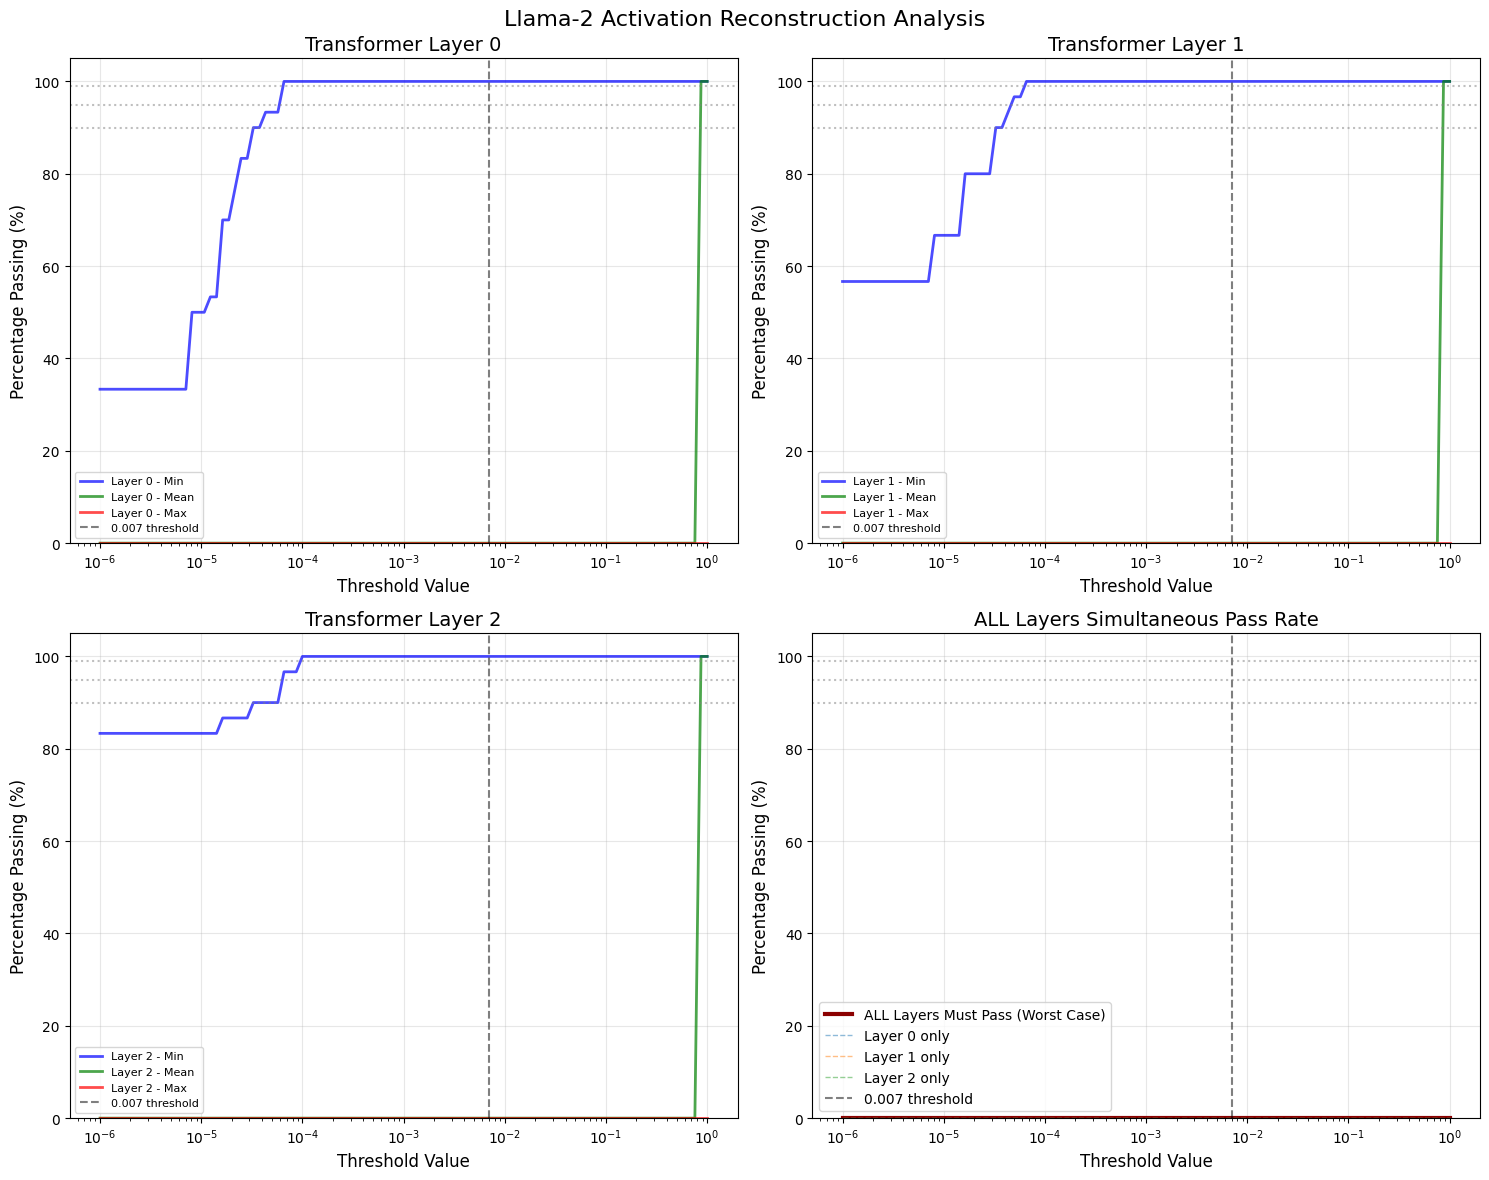


Llama-2 Threshold Analysis Table:
     Layer  Threshold Min Pass % Mean Pass % Max Pass %
   Layer 0      0.001     100.0%        0.0%       0.0%
   Layer 0      0.005     100.0%        0.0%       0.0%
   Layer 0      0.007     100.0%        0.0%       0.0%
   Layer 0      0.010     100.0%        0.0%       0.0%
   Layer 0      0.050     100.0%        0.0%       0.0%
   Layer 0      0.100     100.0%        0.0%       0.0%
   Layer 1      0.001     100.0%        0.0%       0.0%
   Layer 1      0.005     100.0%        0.0%       0.0%
   Layer 1      0.007     100.0%        0.0%       0.0%
   Layer 1      0.010     100.0%        0.0%       0.0%
   Layer 1      0.050     100.0%        0.0%       0.0%
   Layer 1      0.100     100.0%        0.0%       0.0%
   Layer 2      0.001     100.0%        0.0%       0.0%
   Layer 2      0.005     100.0%        0.0%       0.0%
   Layer 2      0.007     100.0%        0.0%       0.0%
   Layer 2      0.010     100.0%        0.0%       0.0%
   Layer 2   

In [10]:
# Define threshold values to test
thresholds = np.logspace(-6, 0, 100)  # From 1e-6 to 1

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Llama-2 Activation Reconstruction Analysis', fontsize=16)

layers = ['0', '1', '2']  # Layer numbers
metrics = ['min_abs_diff', 'mean_abs_diff', 'max_abs_diff']
colors = {'min_abs_diff': 'blue', 'mean_abs_diff': 'green', 'max_abs_diff': 'red'}

# Plot for each layer
for idx, layer in enumerate(layers):
    if idx < 3:  # Only plot first 3 layers
        ax = axes[idx//2, idx%2]
        
        for metric in metrics:
            column = f'layer_{layer}_{metric}'
            if column in results.columns:
                values = results[column].values
                
                # Calculate percentage passing each threshold
                percentages = []
                for threshold in thresholds:
                    passing = np.sum(values <= threshold) / len(values) * 100
                    percentages.append(passing)
                
                # Plot cumulative distribution
                ax.semilogx(thresholds, percentages, 
                           label=f'Layer {layer} - {metric.replace("_abs_diff", "").capitalize()}',
                           color=colors[metric], linewidth=2, alpha=0.7)
        
        # Add reference lines
        ax.axvline(x=0.007, color='black', linestyle='--', alpha=0.5, label='0.007 threshold')
        ax.axhline(y=90, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=95, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=99, color='gray', linestyle=':', alpha=0.5)
        
        ax.set_xlabel('Threshold Value', fontsize=12)
        ax.set_ylabel('Percentage Passing (%)', fontsize=12)
        ax.set_title(f'Transformer Layer {layer}', fontsize=14)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 105)

# Plot ALL LAYERS simultaneous check
ax = axes[1, 1]

if 'all_layers_max_diff' in results.columns:
    values = results['all_layers_max_diff'].values
    percentages_all = []
    for threshold in thresholds:
        passing = np.sum(values <= threshold) / len(values) * 100
        percentages_all.append(passing)
    
    ax.semilogx(thresholds, percentages_all, 
               label='ALL Layers Must Pass (Worst Case)',
               color='darkred', linewidth=3)
    
    # Also plot individual layer maximums for comparison
    for layer in layers:
        column = f'layer_{layer}_max_abs_diff'
        if column in results.columns:
            values = results[column].values
            percentages = []
            for threshold in thresholds:
                passing = np.sum(values <= threshold) / len(values) * 100
                percentages.append(passing)
            ax.semilogx(thresholds, percentages, 
                       label=f'Layer {layer} only',
                       linewidth=1, alpha=0.5, linestyle='--')

ax.axvline(x=0.007, color='black', linestyle='--', alpha=0.5, label='0.007 threshold')
ax.axhline(y=90, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=95, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=99, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Threshold Value', fontsize=12)
ax.set_ylabel('Percentage Passing (%)', fontsize=12)
ax.set_title('ALL Layers Simultaneous Pass Rate', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('llama2_activation_reconstruction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Create threshold analysis table
threshold_values = [0.001, 0.005, 0.007, 0.01, 0.05, 0.1]
analysis_results = []

# Individual layer analysis
for layer in layers:
    for threshold in threshold_values:
        row = {'Layer': f'Layer {layer}', 'Threshold': threshold}
        
        for metric in metrics:
            column = f'layer_{layer}_{metric}'
            if column in results.columns:
                values = results[column].values
                passing_percentage = np.sum(values <= threshold) / len(values) * 100
                row[f'{metric.replace("_abs_diff", "").capitalize()} Pass %'] = f'{passing_percentage:.1f}%'
        
        analysis_results.append(row)

# ALL LAYERS analysis
if 'all_layers_max_diff' in results.columns:
    for threshold in threshold_values:
        row = {'Layer': 'ALL LAYERS', 'Threshold': threshold}
        
        values = results['all_layers_max_diff'].values
        passing_percentage = np.sum(values <= threshold) / len(values) * 100
        row['Min Pass %'] = '-'
        row['Mean Pass %'] = '-'
        row['Max Pass %'] = f'{passing_percentage:.1f}%'
        
        analysis_results.append(row)

# Create DataFrame and display
threshold_df = pd.DataFrame(analysis_results)
print("\nLlama-2 Threshold Analysis Table:")
print("="*80)
print(threshold_df.to_string(index=False))

# Save to CSV
threshold_df.to_csv('llama2_threshold_analysis.csv', index=False)

# %%
# Summary statistics
print("\n" + "="*80)
print("LLAMA-2 ACTIVATION RECONSTRUCTION ANALYSIS SUMMARY")
print("="*80)

if 'all_layers_max_diff' in results.columns:
    values = results['all_layers_max_diff'].values
    
    print(f"\nDataset size: {len(results)} reconstruction attempts")
    print(f"Layers analyzed: {layers}")
    
    # Find threshold for different pass rates
    pass_rates = [90, 95, 99]
    print("\nThreshold needed for target pass rates (ALL LAYERS):")
    
    for rate in pass_rates:
        if len(values) > 0:
            threshold_for_rate = np.percentile(values, rate)
            print(f"  {rate}% pass rate: {threshold_for_rate:.6f}")
    
    # Statistics at specific thresholds
    print("\nPass rates at specific thresholds (ALL LAYERS):")
    for threshold in [0.001, 0.007, 0.01, 0.1]:
        pass_rate = np.sum(values <= threshold) / len(values) * 100
        print(f"  Threshold {threshold}: {pass_rate:.1f}% pass rate")

print("\nAnalysis completed! Check the generated plots and CSV files for detailed results.")

In [ ]:
def generate_comprehensive_visualizations_all_layers(model, results):
    """Generate comprehensive visualizations for ALL layers of Llama 2"""
    
    # Get all layer numbers from the results columns
    layers = sorted(list(set([
        col.split('_')[1] for col in results.columns 
        if col.startswith('layer_') and col.split('_')[2] in ['min', 'mean', 'max']
    ])))
    
    metrics = ['min_abs_diff', 'mean_abs_diff', 'max_abs_diff']
    
    # 1. Layer Activation Distributions (Multiple Pages)
    layers_per_page = 4
    for page_start in range(0, len(layers), layers_per_page):
        page_layers = layers[page_start:page_start + layers_per_page]
        plt.figure(figsize=(20, 5))
        
        for i, layer in enumerate(page_layers, 1):
            plt.subplot(1, layers_per_page, i)
            for metric in metrics:
                column = f'layer_{layer}_{metric}'
                if column in results.columns:
                    sns.kdeplot(data=results[column], label=metric.replace('_abs_diff', ''))
            plt.title(f'Layer {layer} Activations')
            plt.xlabel('Absolute Difference')
            plt.ylabel('Density')
            plt.legend()
        plt.tight_layout()
        plt.savefig(f'llama2_activations_page_{page_start//layers_per_page + 1}.png')
        plt.close()

    # 2. Success Rates Across All Layers
    threshold_values = [0.001, 0.003, 0.005, 0.007, 0.01, 0.05]
    success_rates = []
    
    for threshold in threshold_values:
        rates = {'threshold': threshold}
        for layer in layers:
            column = f'layer_{layer}_max_abs_diff'
            if column in results.columns:
                rate = (results[column] <= threshold).mean() * 100
                rates[f'Layer_{layer}'] = rate
        success_rates.append(rates)
    
    success_df = pd.DataFrame(success_rates)
    
    # Plot success rates (multiple lines)
    plt.figure(figsize=(15, 8))
    for layer in layers:
        if f'Layer_{layer}' in success_df.columns:
            plt.plot(success_df['threshold'], 
                    success_df[f'Layer_{layer}'], 
                    label=f'Layer {layer}',
                    alpha=0.7)
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Threshold')
    plt.ylabel('Success Rate (%)')
    plt.title('Success Rates Across All Layers')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('llama2_all_layers_success_rates.png')
    plt.close()

    # 3. Layer Performance Heatmap
    performance_data = pd.DataFrame(index=layers)
    for threshold in [0.001, 0.007, 0.01]:
        rates = []
        for layer in layers:
            column = f'layer_{layer}_max_abs_diff'
            if column in results.columns:
                rate = (results[column] <= threshold).mean() * 100
                rates.append(rate)
        performance_data[f'thresh_{threshold}'] = rates
    
    plt.figure(figsize=(10, len(layers)//2))
    sns.heatmap(performance_data, annot=True, fmt='.1f', cmap='RdYlGn',
                cbar_kws={'label': 'Success Rate (%)'})
    plt.title('Layer Performance at Different Thresholds')
    plt.tight_layout()
    plt.savefig('llama2_layer_performance_heatmap.png')
    plt.close()

    # 4. Layer Difficulty Analysis
    difficulty_metrics = pd.DataFrame(index=layers)
    for layer in layers:
        column = f'layer_{layer}_max_abs_diff'
        if column in results.columns:
            difficulty_metrics.loc[layer, 'Median'] = results[column].median()
            difficulty_metrics.loc[layer, '90th Percentile'] = results[column].quantile(0.9)
            difficulty_metrics.loc[layer, '99th Percentile'] = results[column].quantile(0.99)
    
    plt.figure(figsize=(15, 8))
    difficulty_metrics.plot(marker='o')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Layer')
    plt.ylabel('Activation Difference')
    plt.title('Layer Difficulty Analysis')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('llama2_layer_difficulty.png')
    plt.close()

    # 5. Cross-Layer Correlation Analysis
    max_diff_columns = [f'layer_{l}_max_abs_diff' for l in layers 
                       if f'layer_{l}_max_abs_diff' in results.columns]
    correlation_matrix = results[max_diff_columns].corr()
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlBu', center=0)
    plt.title('Cross-Layer Correlation of Maximum Differences')
    plt.tight_layout()
    plt.savefig('llama2_cross_layer_correlation.png')
    plt.close()

    # 6. Layer-wise Success Distribution
    threshold = 0.007
    success_distribution = pd.DataFrame(index=['Pass Rate'])
    
    for layer in layers:
        column = f'layer_{layer}_max_abs_diff'
        if column in results.columns:
            success_distribution[f'Layer_{layer}'] = [(results[column] <= threshold).mean() * 100]
    
    plt.figure(figsize=(15, 6))
    success_distribution.T.plot(kind='bar')
    plt.axhline(y=90, color='r', linestyle='--', alpha=0.5, label='90% target')
    plt.grid(True, alpha=0.3)
    plt.title(f'Layer-wise Success Distribution (threshold={threshold})')
    plt.xlabel('Layer')
    plt.ylabel('Pass Rate (%)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('llama2_layer_success_distribution.png')
    plt.close()

    # Save summary statistics
    summary_stats = pd.DataFrame(index=layers)
    for layer in layers:
        column = f'layer_{layer}_max_abs_diff'
        if column in results.columns:
            data = results[column]
            summary_stats.loc[layer, 'Mean'] = data.mean()
            summary_stats.loc[layer, 'Median'] = data.median()
            summary_stats.loc[layer, 'Std'] = data.std()
            summary_stats.loc[layer, 'Pass_Rate_0.007'] = (data <= 0.007).mean() * 100
    
    summary_stats.to_csv('llama2_layer_summary_stats.csv')

    return summary_stats